In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from phase_transition_experiment.sample_survival_poisson import sample_survival_poisson
from survival import evaluate_test_stats
#from phase_transition_experiment.run_experiment import evaluate_test_stats

In [2]:
# single experiment non-null

T = 1000
N1 = N2 = 10000
beta = .7         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = .5
N0 = 2 * N1 * N2 / (N1 + N2)

lam0 = np.ones(T) / T
Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam0, eps, r)

Ot1 = -np.diff(Nt1)
Ot2 = -np.diff(Nt2)
res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2)
res

{'log_rank_greater': 0.9117832601143137,
 'log_rank_pval_greater': 0.18094141209851966,
 'hc_greater': 17.46837998479078,
 'fisher_greater': 1545.470898662807,
 'fisher_pval_greater': 0.9999999999999936,
 'min_p_greater': 12.632054592546213,
 'berk_jones_greater': 46.051701859880914,
 'wilcoxon_greater': 1.1068216695139017,
 'log_rank_less': 0.9117832601143137,
 'log_rank_pval_less': 0.8190585879014803,
 'hc_less': -1.3736420819572581,
 'fisher_less': 1473.9985268185844,
 'fisher_pval_less': 1.0,
 'min_p_less': 5.615085964896305,
 'berk_jones_less': 46.051701859880914,
 'wilcoxon_less': 0.40138555287086697}

In [108]:
def sample_survival_cox(T, N1, N2, lam0, gamma):
    Nt1 = np.zeros(T + 1)
    Nt2 = np.zeros(T + 1)

    lam1 = lam0 * np.ones(T)  # `base` Poisson rates (does not have to be fixed)
    lam2 = lam1.copy()
    tt = np.arange(T)
    lam2 = lam0 + gamma

    Nt1[0] = N1
    Nt2[0] = N2

    for t in np.arange(T):
        O1 = poisson.rvs(Nt1[t] * lam1[t] * (Nt1[t] > 0))
        O2 = poisson.rvs(Nt2[t] * lam2[t] * (Nt2[t] > 0))

        Nt1[t + 1] = np.maximum(Nt1[t] - O1, 0)
        Nt2[t + 1] = np.maximum(Nt2[t] - O2, 0)
    return Nt1, Nt2


In [169]:
df0 = pd.DataFrame()
T = 1000
N1 = 5000
N2 = 5000
gamma = 0

nMonte = 10000
for i in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_cox(T, N1, N2, lam0, gamma)
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2, randomize=False)
    df0 = df0.append(res, ignore_index=True)
df0.to_csv(f"null_T{T}_N{N1}_M{nMonte}_randomized.csv")

100%|██████████| 10000/10000 [16:24<00:00, 10.16it/s]


In [170]:
randomize = False
df0.to_csv(f"null_T{T}_N{N1}_M{nMonte}_rnd{randomize}.csv")

In [171]:
from survival import q95
df0.agg([q95])[['log_rank_greater', 'log_rank_pval_greater', 'fisher_greater', 'fisher_pval_greater']]

,log_rank_greater,log_rank_pval_greater,fisher_greater,fisher_pval_greater
q95,1.624346,0.948567,1398.319228,1.0


In [221]:
df = pd.DataFrame()
T = 1000
N1 = 5000
N2 = 5000

gamma = lam0 * 0.01
nMonte = 500

for i in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_cox(T, N1, N2, lam0, gamma)
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2, randomize=False)
    df = df.append(res, ignore_index=True)

100%|██████████| 500/500 [00:49<00:00, 10.10it/s]


In [173]:
for stat_name in ['fisher_greater', 'log_rank_greater']:
    crit_val = df0.agg([q95])[stat_name].values[0]
    level = np.mean(df0[stat_name] > crit_val)
    acc = np.mean(df[stat_name] > crit_val)
    print(f"Level {stat_name} = ", level)
    print(f"Acc {stat_name} = ", acc)

Level fisher_greater =  0.05
Acc fisher_greater =  0.108
Level log_rank_greater =  0.05
Acc log_rank_greater =  0.122


In [204]:
# num of failures until getting N1 successes; prob of success is p
N1 = 100
N2 = 100


84

In [163]:
df[stat_name]

0      1527.572203
1      1542.415456
2      1578.193167
3      1526.327266
4      1566.903951
          ...     
495    1545.840177
496    1495.603350
497    1611.265302
498    1503.560472
499    1468.022453
Name: fisher_greater, Length: 500, dtype: float64

In [145]:
df[stat_name] > 1.642

0       True
1      False
2      False
3      False
4       True
       ...  
495    False
496    False
497     True
498     True
499    False
Name: log_rank_greater, Length: 500, dtype: bool

In [81]:
from survival import multi_pvals
gamma = 0
Nt1, Nt2 = sample_survival_cox(T, N1, N2, gamma)
Ot1 = -np.diff(Nt1)
Ot2 = -np.diff(Nt2)

pvals = multi_pvals(Nt1[:-1], Nt2[:-1], Ot1, Ot2, alternative='greater', randomize=True)
pvals = pvals[pvals < 1]
mt = MultiTest(pvals, stbl=False)

fisher = mt.fisher()
fisher

(1977.5239247906038, 0.6353913610507772)

In [51]:
len(pvals)

471

(array([ 13.,  49.,   9.,   0., 225.,   2.,  46.,  82.,  40., 534.]),
 array([0.10640436, 0.19576393, 0.28512349, 0.37448305, 0.46384262,
        0.55320218, 0.64256174, 0.73192131, 0.82128087, 0.91064044,
        1.        ]),
 <BarContainer object of 10 artists>)

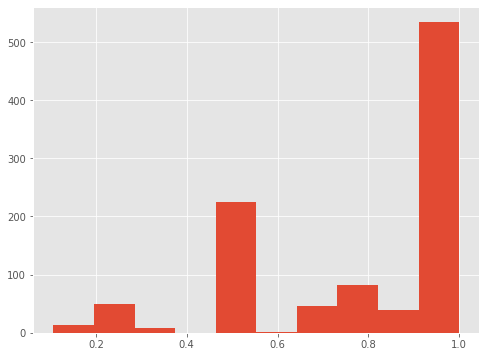

In [56]:
plt.hist(multi_pvals(Nt1[:-1], Nt2[:-1], Ot1, Ot2, alternative='greater'))